In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import constants as cons

from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 

import matplotlib.style as style
style.use('fivethirtyeight')
import time

In [4]:
df = pd.read_csv(cons.file_path, index_col=0)
df_raw = df.copy()

In [5]:
###################################### EXPLORE ######################################

In [6]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [7]:
df.shape

(84548, 21)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84548 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null  int6

In [9]:
###################################### FEATURE ENGINEERING ######################################

In [10]:
# First, let's convert few columns which are categorical 
# into integer values, so that it is easy for machine to handle values.

def sale(string):
    if ('-' in string):
        return np.NaN
    else:
        return int(string)
    
def year_built(string):
    if string==0:
        return np.NaN
    elif ('-' in string):
        return np.NaN
    else:
        return int(string)
    
df['SALE PRICE'] = df['SALE PRICE'].map(lambda x: sale(x))
df['YEAR BUILT'] = df['YEAR BUILT'].map(lambda x: int(x))
df['YEAR SOLD'] = df['SALE DATE'].map(lambda x: x[0:4])
df['YEAR SOLD'] = df['YEAR SOLD'].map(lambda x: int(x))
df['MONTH SOLD'] = df['SALE DATE'].map(lambda x: x[5:7])
df['MONTH SOLD'] = df['MONTH SOLD'].map(lambda x: int(x))
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].map(lambda x: year_built(x))
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].map(lambda x: year_built(x))
df['YEAR BUILT'][df['YEAR BUILT']==0]=np.NaN

# if you see our data, it include somme missing values it represent it like '-' we will replace it by nan
# blank rows should instead be null values

map_dict={'-':np.nan,' ':np.nan}
df.replace(map_dict,inplace = True)

df = df.replace(to_replace=r'^\s*[-]\s*', value=np.nan, regex=True)

<Axes: >

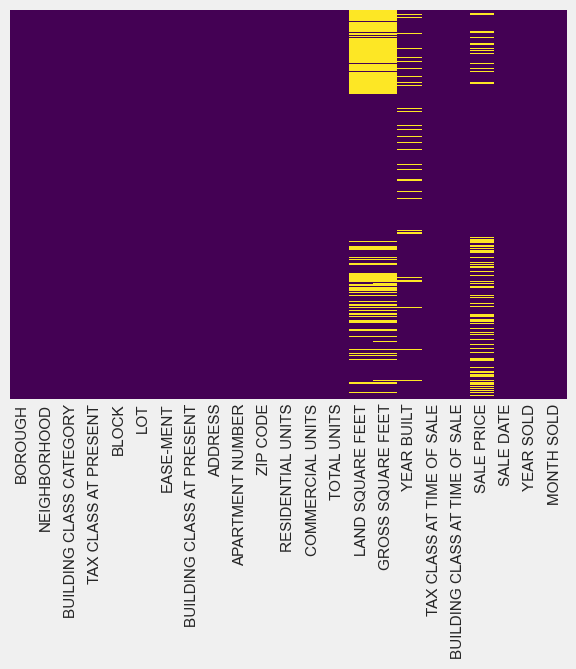

In [11]:
sns.heatmap(
    df.isnull(), 
    yticklabels=False, 
    cbar=False, 
    cmap='viridis'
)

<img src="data/Boroughs_New_York.png" alt="Image caption" width="500" height="200">

<img src="data/Boroughs_New_York_City_Map.png" alt="Image caption" width="400" height="300">

Text(0.5, 1.0, 'Sales per Borough')

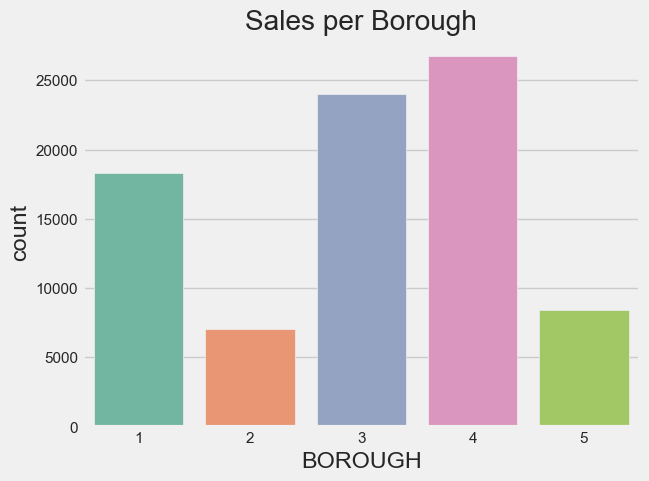

In [12]:
sns.countplot(x='BOROUGH', data=df, palette='Set2')
plt.title('Sales per Borough')

# Maximum properties are sold in Queens! followed by Staten Island!

Text(0.5, 1.0, 'Sales per Borough Residential')

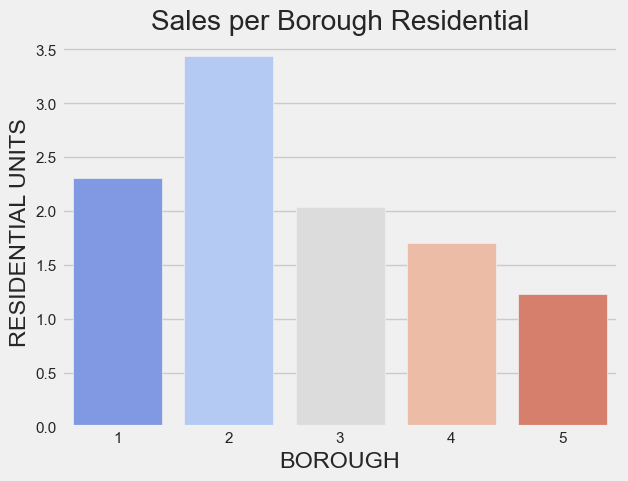

In [13]:
sns.barplot(y='RESIDENTIAL UNITS', x='BOROUGH',data=df, palette='coolwarm', ci=None)
plt.title('Sales per Borough Residential')

# Residential Units are mainly sold in ...

Text(0.5, 1.0, 'Sales per Borough Commercial')

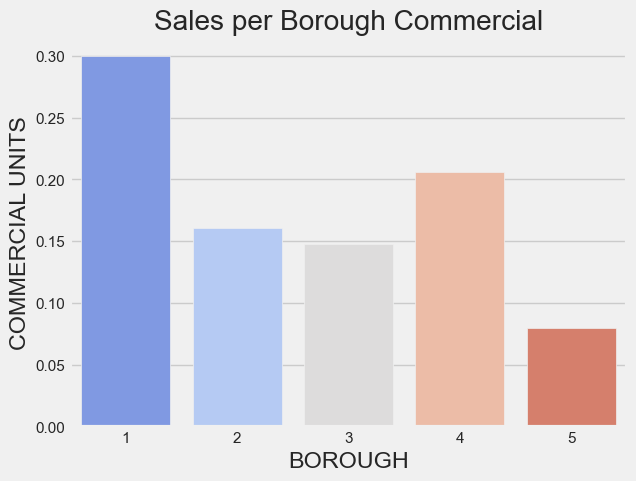

In [14]:
sns.barplot(y='COMMERCIAL UNITS', x='BOROUGH',data=df, palette='coolwarm', ci=None)
plt.title('Sales per Borough Commercial')

Text(0.5, 1.0, 'Sales Rate from 2016-2017')

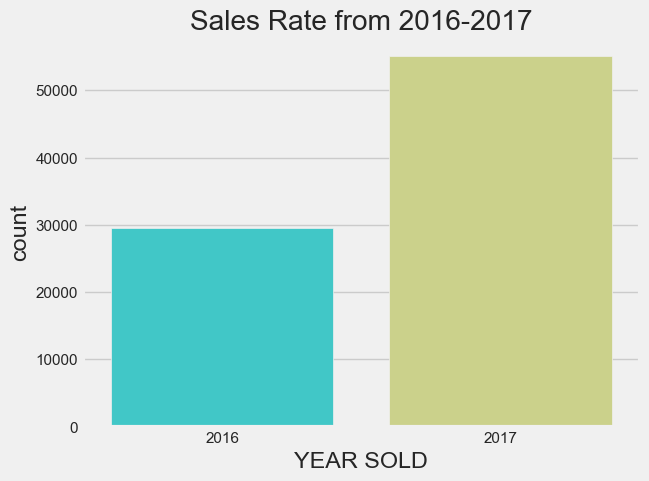

In [15]:
sns.countplot(x='YEAR SOLD', data=df, palette='rainbow')
plt.title('Sales Rate from 2016-2017')

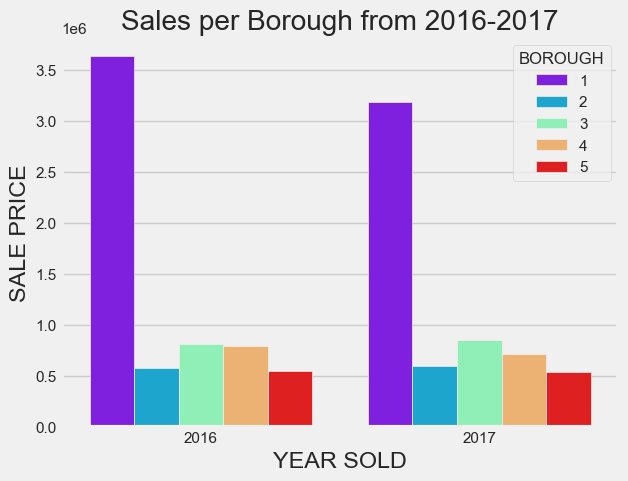

In [16]:
summary_data = df.groupby(['YEAR SOLD', 'BOROUGH'])['SALE PRICE'].mean().reset_index()

# Barplot'u oluşturun
sns.barplot(
    x='YEAR SOLD', 
    y='SALE PRICE', 
    hue='BOROUGH', 
    data=summary_data, 
    palette='rainbow', 
    ci=None
)
plt.title('Sales per Borough from 2016-2017')
plt.show()

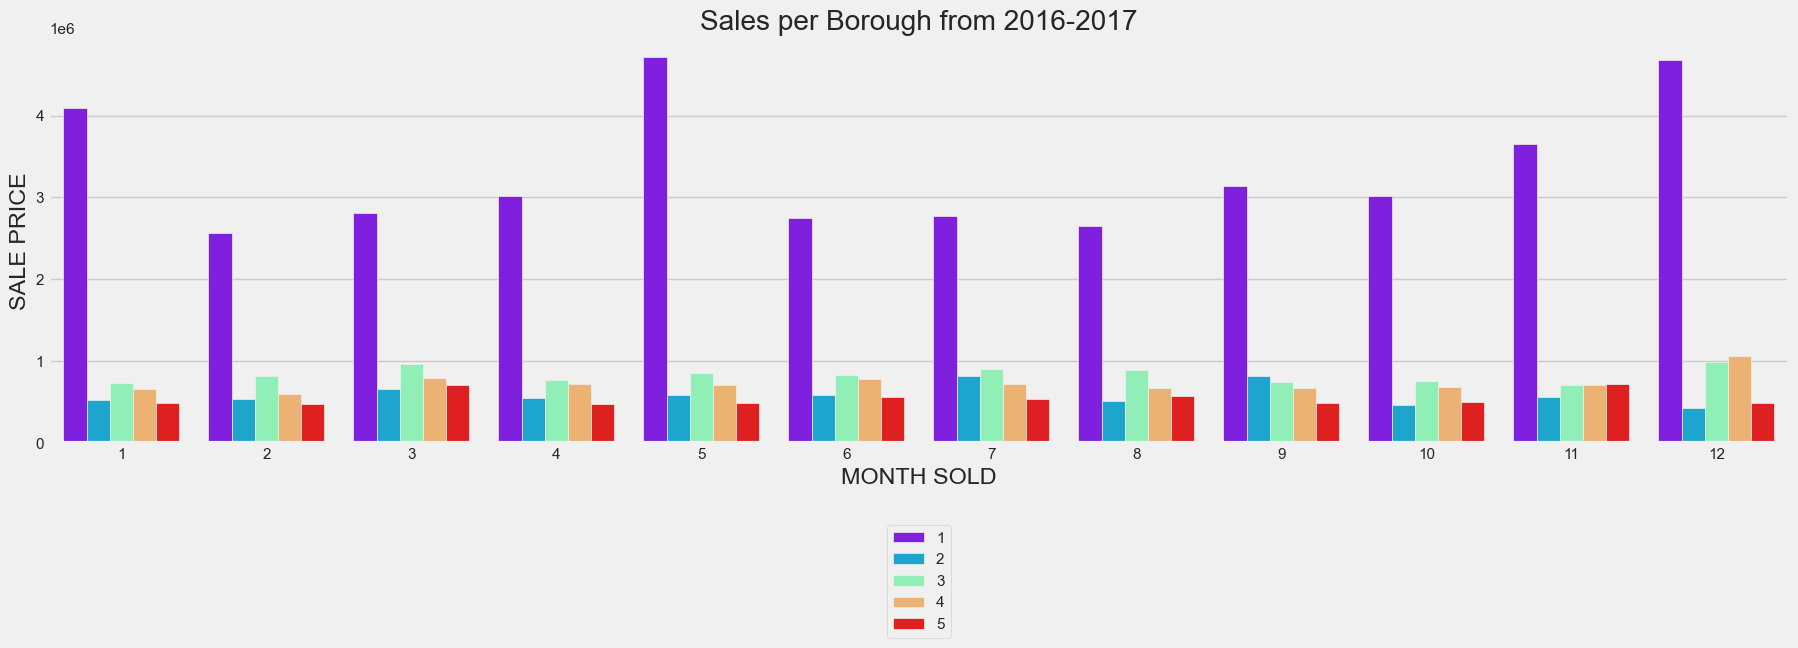

In [17]:
summary_data = df.groupby(['MONTH SOLD', 'BOROUGH'])['SALE PRICE'].mean().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(
    x='MONTH SOLD', 
    y='SALE PRICE', 
    hue='BOROUGH', 
    data=summary_data, 
    palette='rainbow', 
    ci=None
)
plt.title('Sales per Borough from 2016-2017')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
plt.show()

'\nIt is noticed that though the number of sales increased from the year 2016 to 2017, \nthe sales prices per Borough(location) remained in the same ranges\nAlso, the property prices are much higher at Manhattan than at any other location.\nAs per months, property sales for 2017 took place from January till August, \nand for 2016 from September till December.'

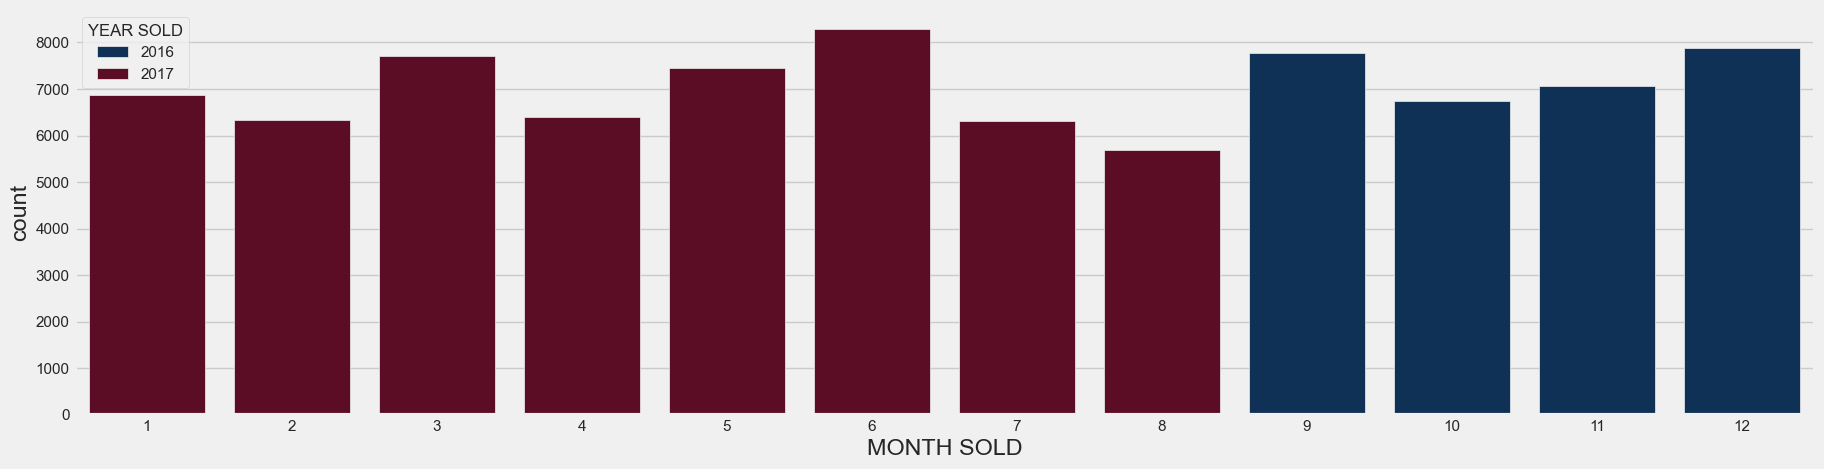

In [18]:
plt.figure(figsize=(20,5))
sns.countplot(x='MONTH SOLD', hue='YEAR SOLD', data=df, palette='RdBu_r')

"""
It is noticed that though the number of sales increased from the year 2016 to 2017, 
the sales prices per Borough(location) remained in the same ranges
Also, the property prices are much higher at Manhattan than at any other location.
As per months, property sales for 2017 took place from January till August, 
and for 2016 from September till December."""

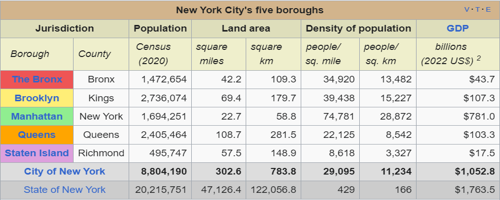

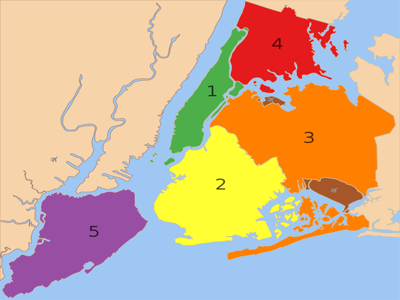

In [19]:
############################## DATA TYPE ANALYSIS ##########################################

In [ ]:
df['BUILDING AGE'] = 2017 - df['YEAR BUILT']
df['BOROUGH'] = df['BOROUGH'].map(cons.borough_encoding)
df['SALE_YEAR'] = pd.DatetimeIndex(df[cons.date_column]).year
df['SALE_MONTH'] = pd.DatetimeIndex(df[cons.date_column]).month


del df["YEAR BUILT"] 
del df["BUILDING CLASS AT PRESENT"] # It contains the same information with BUILDING CLASS CATEGORY
del df["ADDRESS"] # The variable 1 not required for the model
del df["ZIP CODE"] # The variable 2 not required for the model
del df["SALE DATE"] # We don't need it as we have created the year and month variables.
df.drop(["EASE-MENT","APARTMENT NUMBER"], axis=1, inplace=True) # Completely empty columns.

In [ ]:


df[cons.date_column] = pd.to_datetime(df[cons.date_column], errors='coerce') 

for col in cons.numeric_columns: 
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in cons.categorical_columns: 
    df[col] = df[col].astype(object)

def get_categorical_and_numeric_columns(dataframe, number_of_unique_classes):
    categorical_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) <= number_of_unique_classes
                          or dataframe[col].dtype == "O"]
    
    new_categorical_columns = []
    for cat_cols in categorical_columns:
        new_categorical_columns.append(cat_cols)
        
    numeric_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) > number_of_unique_classes
                       and dataframe[col].dtype != "O" or col not in new_categorical_columns]
    numeric_columns.remove(cons.target_variable)  
    return new_categorical_columns, numeric_columns

def unique_value_analysis(dataframe, number_of_unique_classes):
    check_flag = 0
    for i in range(0, len(number_of_unique_classes)):
        cat_cols, num_cols = get_categorical_and_numeric_columns(dataframe, number_of_unique_classes[i])
        print('Number of Unique Value:',number_of_unique_classes[i],' Number of Categorical Value:',len(cat_cols),' Number of Numerical Value: ', len(num_cols))
        if check_flag < len(cat_cols)*1.1 and check_flag > 0:
            return number_of_unique_classes[i]
        else:
            check_flag = len(cat_cols)

In [ ]:
threshold_value = unique_value_analysis(df,[2, 3, 5, 10, 20, 50])
print("threshold_value: ", threshold_value)
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

In [ ]:
df[cat_cols].head()

In [ ]:
df[num_cols].head()

In [ ]:
#################### FILLING MISSING VALUES #########################

In [ ]:
#### MISSING DATA ANALYSIS

df.replace(' ',np.nan, inplace=True)
round(df.isna().sum() /len(df) *100,2)

In [ ]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    missing_df.reset_index(inplace=True)
    missing_df = missing_df.rename(columns = {'index':'Columns Name'})
    return missing_df
##################################################################################################################

def missing_vs_target(dataframe,target,variable_with_na):
    temp_df = dataframe.copy()
    for variable in variable_with_na:
        temp_df[variable + '_NA_FLAG'] = np.where(temp_df[variable].isnull(), 1, 0)    
    flags_na = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for variable in flags_na:
        print(pd.DataFrame({'TARGET_MEAN': temp_df.groupby(variable)[target].mean()}),end='\n\n\n')

missing_df = missing_values_table(df)
missing_df

In [ ]:
missing_drop_list = missing_df[missing_df['ratio']>40]['Columns Name'].values.tolist()
print(len(missing_drop_list), 'number of columns are removed.')
df.drop(missing_drop_list, axis=1, inplace=True)

In [ ]:
# Imputing missing values in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' using the median
for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Removing rows where 'SALE PRICE' is missing
# Deleting 0 price transfer transactions
# Deleting nan values of dependence variable

df = df[df["SALE PRICE"] > 0]  
df = df[df["SALE PRICE"].notnull()] 


# Checking the changes made
df_info = {
    "Missing Values After Imputation": df[numeric_columns].isnull().sum(),
    "Remaining Rows": len(df)
}

df_info

In [ ]:
# Square feet should not be 0.
df = df[df["LAND SQUARE FEET"] != 0]
df = df[df["GROSS SQUARE FEET"] != 0]

df = df.dropna() 
df.drop_duplicates(keep = "last", inplace=True)

In [ ]:
# Removing data where commercial + residential doesn't equal total units
df = df[df['TOTAL UNITS'] == df['COMMERCIAL UNITS'] + df['RESIDENTIAL UNITS']]
df[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

In [ ]:
# Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units
df = df[(df['TOTAL UNITS'] > 0) & (df['TOTAL UNITS'] != 2261)]

df.shape

In [ ]:
################ OUTLIER ANALYSIS

df_after_missing = df.copy()
round(df.describe([0.75,0.85,0.95,0.99,0.995,0.999]),3)

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################

def replace_with_thresholds(dataframe, columns_list):
    for variable in columns_list:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        if low_limit < 0:
            low_limit = 0
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################

def remove_outliers(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe_without_outliers = dataframe[~((dataframe[variable] < low_limit) | (dataframe[variable] > up_limit))]
    return dataframe_without_outliers
##################################################################################################################

def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [ ]:
outlier_variable_names = has_outliers(df, num_cols)

In [ ]:
del df["LOT"]

In [ ]:
############## VISUALIZE

sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
plotd = sns.distplot(df[(df['SALE PRICE']>100) & (df['SALE PRICE'] < 5000000)]['SALE PRICE'], kde=True, bins=100)

tick_spacing=250000
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([-100000, 5000000])
plt.xticks(rotation=30)
plt.axvline(df[(df['SALE PRICE']>100) & (df['SALE PRICE'] < 5000000)]['SALE PRICE'].mean(), c='red')
plt.axvline(df[(df['SALE PRICE']>100) & (df['SALE PRICE'] < 5000000)]['SALE PRICE'].median(), c='blue')
plt.text(250000,0.0000012, "median")
plt.text(850000,0.0000010, "mean")
plt.show()

In [ ]:
m = df.select_dtypes(np.number)
df[m.columns]= m.round().astype('Int64')
pd.options.display.float_format = '{:,.0f}'.format
df.rename(columns = {"SALE PRICE":"sale_price"},inplace = True)

In [ ]:
df2 = df[(df['sale_price'] > 100000) & (df['sale_price'] < 5000000)]

trace0 = go.Box(
    y=df2.sale_price[df2.BOROUGH == 'Manhattan' ],
    name = 'Manhattan',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace1 = go.Box(
    y=df2.sale_price[df2.BOROUGH ==  'Bronx' ],
    name = 'Bronx',
    marker = dict(
        color = 'rgb(8,81,156)',
    )
)
trace2 = go.Box(
    y=df2.sale_price[df2.BOROUGH ==  'Brooklyn' ],
    name = 'Brooklyn',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)
trace3 = go.Box(
    y=df2.sale_price[df2.BOROUGH ==  'Queens' ],
    name = 'Queens',
    marker = dict(
        color = 'rgb(12, 128, 128)',
    )
)
trace4 = go.Box(
    y=df2.sale_price[df2.BOROUGH ==  'Staten Island' ],
    name = 'Staten Island',
    marker = dict(
        color = 'rgb(12, 12, 140)',
    )
)

dat = [trace0, trace1, trace2, trace3, trace4]
layout = go.Layout(
    title='Housing Prices by Boroughs',
    xaxis=dict(
        title='Borough'
    ),
    yaxis=dict(
        title='Sale Price'
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=dat, layout=layout)
py.iplot(fig)

In [ ]:
df_bar=df[['SALE_MONTH', 'sale_price']].groupby(by='SALE_MONTH').count().sort_values(by='SALE_MONTH', ascending=True).reset_index()
df_bar.columns.values[1]='Sales_count'

plt.figure(figsize=(12,6))
sns.barplot(y = 'Sales_count', x = 'SALE_MONTH', data = df_bar)
plt.title('Sale Count by Months')
plt.show()

In [ ]:
# There is no seasonality for house prices. So we can delete theese columns.
del df["SALE_YEAR"]
del df["SALE_MONTH"]

In [ ]:
plt.figure(figsize=(16,6))
order = sorted(df['BUILDING CLASS CATEGORY'].unique())
sns.boxplot(x='BUILDING CLASS CATEGORY', y='sale_price', data=df, order=order)
plt.xticks(rotation=90)
plt.title('Sale Prices by Building Class Category')
plt.show()

In [ ]:
dataset = df[
    (df['COMMERCIAL UNITS']<20) & (df['TOTAL UNITS']<50) & 
    (df['sale_price']<5000000) & (df['sale_price']>100000) & 
    (df['GROSS SQUARE FEET']>0)
    ]

plt.figure(figsize=(14,6))
sns.boxplot(x='COMMERCIAL UNITS', y="sale_price", data=dataset)
plt.title('Sale Prices by Commercial Units')

In [ ]:
# Deleting of unnecessary categorical variables for the model

del df["NEIGHBORHOOD"]
del df['BUILDING CLASS AT TIME OF SALE']
del df['TAX CLASS AT PRESENT']

In [ ]:
#Fixing all column names to be lowercase and no spaces
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.tax_class_at_time_of_sale = df.tax_class_at_time_of_sale.astype(object)

In [ ]:
X = df.drop(
    ["sale_price","building_class_category","borough","tax_class_at_time_of_sale"],
    axis = 1
    ).astype(int)

y = df["sale_price"].astype(int)

In [ ]:
X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
################################# BASE MODEL
# Popular Regression Algorithms

lm = LinearRegression()
rf = RandomForestRegressor(random_state = 42)
lgbm = lightgbm.LGBMRegressor(random_state = 42)


algo = [lm, lgbm, rf]
result = []

for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sn")
        
result_raw_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
result_raw_model

In [ ]:
del df["residential_units"]
del df["total_units"]

In [ ]:
del df["building_age"]

In [ ]:
# Creating dummy variables from categorical variables

one_hot_variables = ["borough","building_class_category","tax_class_at_time_of_sale"]
df = pd.get_dummies(df,prefix = one_hot_variables, prefix_sep = "_" , drop_first = True)

In [ ]:
X = df.drop(["sale_price"],axis = 1).astype(int)
y = df["sale_price"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
algo = [lgbm, lm, rf]
result = []

for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_processed"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sec")
        
result_second_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")

In [ ]:
result_second_model.head(2)

In [ ]:
result_raw_model.head(2)

In [ ]:
model = lr_tuned.best_estimator_.fit(X_train,y_train) # Grid Search result

In [ ]:
result_optimize_model = []
result_optimize_model.append(["RandomForestRegressor Optimize", model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])

pd.DataFrame(result_optimize_model, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")

In [ ]:
result_second_model[:1]


In [ ]:
rankings = model.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x="importance",
            y="variable",
            data=importance)
plt.title('Değişken Önemleri')
plt.tight_layout()